# Testing of features in polysaccharide2

In [2]:
# Supressing annoying warnings (!must be done first!)
import warnings
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Logging
from polymerist.genutils.logutils.IOHandlers import LOG_FORMATTER

import logging
logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)

# General
import re, json
from pathlib import Path
from shutil import copyfile

import numpy as np

# Logging
from rich.progress import Progress, track
import logging

# Chemistry
from openmm.unit import nanometer, angstrom
from openff.toolkit import Topology, Molecule, ForceField
from openff.units import unit as offunit

from openff.interchange import Interchange
from openff.interchange.components import _packmol as packmol

from rdkit import Chem
import openeye

# Custom
import polymerist as ps2
from polymerist.genutils.decorators.functional import allow_string_paths, allow_pathlib_paths, optional_in_place

# Building spec-compliant monomers from raw SMILES

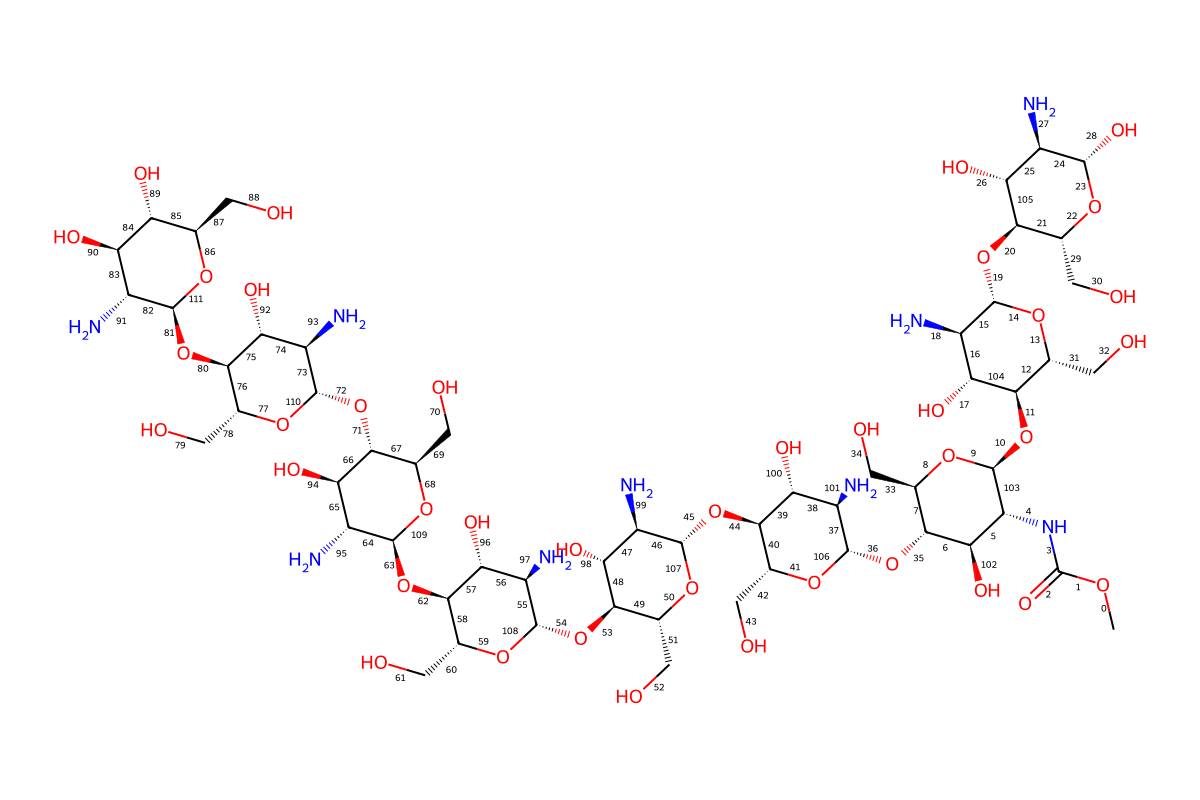

In [3]:
from polymerist.rdutils import rdkdraw
rdkdraw.set_rdkdraw_size(800, 3/2)
from polymerist.rdutils.labeling import molwise

smiles = 'COC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O[C@@H]2[C@H](O[C@H]([C@@H]([C@H]2O)N)O[C@@H]3[C@H](O[C@H]([C@@H]([C@H]3O)N)O)CO)CO)CO)O[C@H]4[C@@H]([C@H]([C@@H]([C@H](O4)CO)O[C@H]5[C@@H]([C@H]([C@@H]([C@H](O5)CO)O[C@H]6[C@@H]([C@H]([C@@H]([C@H](O6)CO)O[C@H]7[C@@H]([C@H]([C@@H]([C@H](O7)CO)O[C@H]8[C@@H]([C@H]([C@@H]([C@H](O8)CO)O[C@H]9[C@@H]([C@H]([C@@H]([C@H](O9)CO)O)O)N)O)N)O)N)O)N)O)N)O)N)O'
rdmol = Chem.MolFromSmiles(smiles)

for i, bond in enumerate(rdmol.GetBonds()):
    bond.SetIntProp('bondNote', i)

display(rdmol)

In [ ]:
break_bonds = [80]
frags = Chem.rdmolops.FragmentOnBonds(rdmol, break_bonds)
frags = Chem.GetMolFrags(frags, asMols=True)

Chem.Draw.MolsToGridImage(frags, molsPerRow=2, subImgSize=(400, 400))

In [ ]:
mono_base = frags[-1]
mono_base = Chem.AddHs(mono_base)
mono_base = molwise.assign_ordered_atom_map_nums(mono_base)

mono_base.GetAtomWithIdx(22-1).SetAtomicNum(0)

Chem.AllChem.EmbedMolecule(mono_base)
display(mono_base)

In [ ]:
Chem.MolToSmarts(mono_base)

In [ ]:
from polymerist.monomers import MonomerGroup

smarts = {
    'glucosamine'       : ['[#8:1](-[#6:2]1(-[#6:3](-[#6:4](-[#6:5](-[#6:6](-[#8:7]-1)(-[#6:8](-[#8:9]-[#1:21])(-[#1:19])-[#1:20])-[#1:18])(-[#8:10]-[1#0:22])-[#1:17])(-[#8:11]-[#1:23])-[#1:16])(-[#7:12](-[#1:24])-[#1:25])-[#1:15])-[#1:14])-[2#0:13]'],
    'glucosamine_TERM1' : ['[#8:1](-[#6:2]1(-[#6:3](-[#6:4](-[#6:5](-[#6:6](-[#8:7]-1)(-[#6:8](-[#8:9]-[#1:21])(-[#1:19])-[#1:20])-[#1:18])(-[#8:10]-[1#0:22])-[#1:17])(-[#8:11]-[#1:23])-[#1:16])(-[#7:12](-[#1:24])-[#1:25])-[#1:15])-[#1:14])-[#1:13]'],
    'glucosamine_TERM2' : ['[#8:1](-[#6:2]1(-[#6:3](-[#6:4](-[#6:5](-[#6:6](-[#8:7]-1)(-[#6:8](-[#8:9]-[#1:21])(-[#1:19])-[#1:20])-[#1:18])(-[#8:10]-[#1:22])-[#1:17])(-[#8:11]-[#1:23])-[#1:16])(-[#7:12](-[#1:24])-[#1:25])-[#1:15])-[#1:14])-[2#0:13]'],
}
term_orient = {
    'glucosamine_TERM1' : 'head',
    'glucosamine_TERM2' : 'tail',
}

grp = MonomerGroup(
    monomers=smarts,
    term_orient=term_orient
)

In [ ]:
rdkdraw.set_rdkdraw_size(300, 3/2)
for resname, mol in grp.iter_rdmols():
    display(mol)

In [ ]:
from mbuild.conversion import from_rdkit
help(from_rdkit)

In [ ]:
from polymerist.polymers.building import build_linear_polymer
from polymerist.rdutils.amalgamation import bonding

prot_mol = bonding.hydrogenate_rdmol_ports(mol, in_place=False)
Chem.SanitizeMol(prot_mol)
molwise.clear_atom_isotopes(prot_mol, in_place=True)

mbmol = from_rdkit(prot_mol)

chain = build_linear_polymer(grp, DOP=5)

In [ ]:
prot_mol

In [ ]:
from polymerist.rdutils.rdconvert import RDConverter
from polymerist.rdutils import rdprops

In [ ]:

cvtr = RDConverter.subclass_registry['SMILES']()

In [ ]:
p = rdprops.clear_atom_props(prot_mol, in_place=False)
g = cvtr._convert(p)
Chem.SanitizeMol(g)

In [ ]:
from_rdkit(g)

In [ ]:
rem = Chem.RemoveAllHs(prot_mol, sanitize=False)
rem

In [ ]:
prot_mol.GetSubstructMatch(rem)

# Playing with ratios

In [ ]:
from dataclasses import dataclass
from typing import Any, Callable, ClassVar, TypeVar
from math import gcd
from numbers import Number


N = TypeVar('N')
def sgnmag(num : N) -> tuple[bool, N]:
    '''Returns the sign and magnitude of a numeric-like value'''
    return num < 0, abs(num)


@dataclass(repr=False)
class Ratio:
    '''For representing fractional ratios between two objects'''
    num   : Any
    denom : Any

    # REPRESENTATION
    def __repr__(self) -> str:
        return f'{self.num}/{self.denom}'
    
    def to_latex(self) -> str:
        '''Return latex-compatible string which represent fraction'''
        return rf'\frac{{{self.num}}}{{{self.denom}}}'

    # RELATIONS
    @property
    def reciprocal(self) -> 'Ratio':
        '''Return the reciprocal of a ration'''
        return self.__class__(self.denom, self.num)


@dataclass(repr=False)
class Rational(Ratio):
    '''For representing ratios of integers'''
    num   : int
    denom : int

    # REDUCTION
    autoreduce : ClassVar[bool]=False
    
    def __post_init__(self) -> None:
        if self.__class__.autoreduce:
            self.reduce()

    def reduce(self) -> None:
        '''Reduce numerator and denominator by greatest common factor'''
        _gcd = gcd(self.num, self.denom)
        self.num=int(self.num / _gcd)
        self.denom=int(self.denom / _gcd)
    simplify = reduce # alias for convenience

    @property
    def reduced(self) -> 'Rational':
        '''Return reduced Rational equivalent to the current rational (does not modify in-place)'''
        new_rat = self.__class__(self.num, self.denom)
        new_rat.reduce()

        return new_rat
    simplifed = reduced # alias for convenience
    
    def as_proper(self) -> tuple[int, 'Rational']:
        '''Returns the integer and proper fractional component of a ratio'''
        integ, remain = divmod(self.num, self.denom)
        return integ, self.__class__(remain, self.denom)
    
    # ARITHMETIC
    def __add__(self, other : 'Rational') -> 'Rational':
        '''Sum of two Rationals'''
        return self.__class__(
            num=(self.num * other.denom) + (self.denom * other.num),
            denom=(self.denom * other.denom)
        )
    
    def __sub__(self, other : 'Rational') -> 'Rational':
        '''Difference of two Rationals'''
        return self.__class__(
            num=(self.num * other.denom) - (self.denom * other.num),
            denom=(self.denom * other.denom)
        )

    def __mul__(self, other : 'Rational') -> 'Rational':
        '''Product of two Rationals'''
        return self.__class__(
            num=self.num * other.num,
            denom=self.denom * other.denom
        )

    def __div__(self, other : 'Rational') -> 'Rational':
        '''Quotient of two Rationals'''
        return self.__class__(
            num=self.num * other.denom,
            denom=self.denom * other.num
        )
    
    def __pow__(self, power : float) -> 'Rational':
        '''Exponentiates a ratio'''
        return self.__class__(
            num=self.num**power,
            denom=self.denom**power
        )

In [ ]:
p = Rational(3, 6)
q = Rational(4, 12)

print(p, p.reciprocal, p.reduced, p+q)

In [ ]:
Rational.autoreduce = False

In [ ]:
import numpy as np
from numbers import Number

for val in (4, 4.0, 4+0j, np.pi, '4', [4], False, 'sgdfg'):
    print(val, type(val), isinstance(val, Number))

In [ ]:
from fractions import Fraction